# Part 1 – NONDERIV_TRANS.tsv Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on the **NONDERIV_TRANS.tsv** file. We focus on:
- Basic structure and missing values
- Filtering to **COMMON stock** and **P/S (Buy/Sell)** transactions
- Distribution of transaction codes
- Transaction dates and time trends
- Shares, price per share, and dollar-value distributions

In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Load data
We load only the relevant columns used in the analysis. That is: 

| **Field Name**        | **Description**                                                                                               | **Data Type**       | **Nullable** | **Key** |
|------------------------|---------------------------------------------------------------------------------------------------------------|---------------------|---------------|----------|
| SECURITY_TITLE         | Security title                                                                                                | VARCHAR2 (60)       | No            |          |
| TRANS_DATE             | Transaction date in (DD-MON-YYYY) format.                                                                     | DATE                | No            |          |
| TRANS_SHARES           | Transaction shares reported when Securities Acquired (A) or Disposed of (D).                                  | NUMBER(16,2)        | Yes           |          |
| TRANS_PRICEPERSHARE    | Price of non-Derivative Transaction Security.                                                                 | NUMBER(16,2)        | Yes           |          |
| TRANS_CODE             | Transaction code (values and descriptions are listed in the Appendix section 6.2 Trans Code List).            | VARCHAR2 (1)        | Yes           |          |


If the file path is different on your system, update `NONDERIV_PATH` accordingly.

In [461]:
NONDERIV_PATH = r"../NONDERIV_TRANS.tsv"  # <-- update this

nonderiv_cols = ['ACCESSION_NUMBER', 'SECURITY_TITLE', 'TRANS_DATE', 'TRANS_SHARES',
                 'TRANS_PRICEPERSHARE', 'TRANS_CODE']

df_nonderiv = pd.read_csv(NONDERIV_PATH, sep='\t', usecols=nonderiv_cols, low_memory=False)
df_nonderiv.head()

,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_DATE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE
0,0001104659-25-030101,"Non-Voting Ordinary Shares, No Par Value",31-MAR-2025,J,1185242.00,3.01
1,0001104659-25-030099,"Non-Voting Ordinary Shares, No Par Value",31-MAR-2025,J,1185242.00,3.01
2,0000950170-25-048015,2024 Annual Restricted Stock Units,27-MAR-2025,A,13.24,NaN
3,0000950170-25-048008,2024 Annual Restricted Stock Units,27-MAR-2025,A,21.47,NaN
4,0000950170-25-048008,2024 Elective Restricted Stock Units,27-MAR-2025,A,5.88,NaN


## Basic information and missing values
We check the **shape**, **data types**, and **missing values** to understand data quality before applying any filters.

In [462]:
print('Shape:', df_nonderiv.shape)
df_nonderiv.dtypes

Shape: (103029, 6)


ACCESSION_NUMBER        object
SECURITY_TITLE          object
TRANS_DATE              object
TRANS_CODE              object
TRANS_SHARES           float64
TRANS_PRICEPERSHARE    float64
dtype: object

In [463]:
missing = df_nonderiv.isnull().sum()
missing_pct = (missing / len(df_nonderiv) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df

,Missing Count,Missing %
ACCESSION_NUMBER,0,0.00
SECURITY_TITLE,0,0.00
TRANS_DATE,0,0.00
TRANS_CODE,1,0.00
TRANS_SHARES,0,0.00
TRANS_PRICEPERSHARE,7714,7.49


## Filter for COMMON stock and P/S transactions
We restrict the dataset to:
- Rows where `SECURITY_TITLE` contains **'COMMON'** (case-insensitive), and
- `TRANS_CODE` is either **'P' (Purchase)** or **'S' (Sale)**.

This focuses the analysis on standard insider buy/sell transactions in common stock.

In [464]:
df_filtered = df_nonderiv[
    df_nonderiv['SECURITY_TITLE'].str.contains('COMMON', case=False, na=False)
    & df_nonderiv['TRANS_CODE'].isin(['P', 'S'])
].copy()

print('Records after filtering:', len(df_filtered))
print('Percentage retained:', round(len(df_filtered) / len(df_nonderiv) * 100, 2), '%')

df_filtered['TRANS_CODE'].value_counts()

Records after filtering: 26190
Percentage retained: 25.42 %


TRANS_CODE
S    20798
P     5392
Name: count, dtype: int64

## 4. Transaction date analysis
We convert `TRANS_DATE` to datetime and derive **year** and **year-month** fields to study temporal patterns.

In [465]:
df_filtered['TRANS_DATE'] = pd.to_datetime(df_filtered['TRANS_DATE'], errors='coerce')
df_filtered['year'] = df_filtered['TRANS_DATE'].dt.year
df_filtered['year_month'] = df_filtered['TRANS_DATE'].dt.to_period('M')

print('Date range:', df_filtered['TRANS_DATE'].min(), 'to', df_filtered['TRANS_DATE'].max())

transactions_by_year = df_filtered['year'].value_counts().sort_index()
transactions_by_year

Date range: 2011-07-26 00:00:00 to 2025-10-24 00:00:00


year
2011        1
2012       29
2014        1
2015        1
2016        1
2017        1
2020        3
2021        9
2022       32
2023       58
2024      991
2025    25063
Name: count, dtype: int64

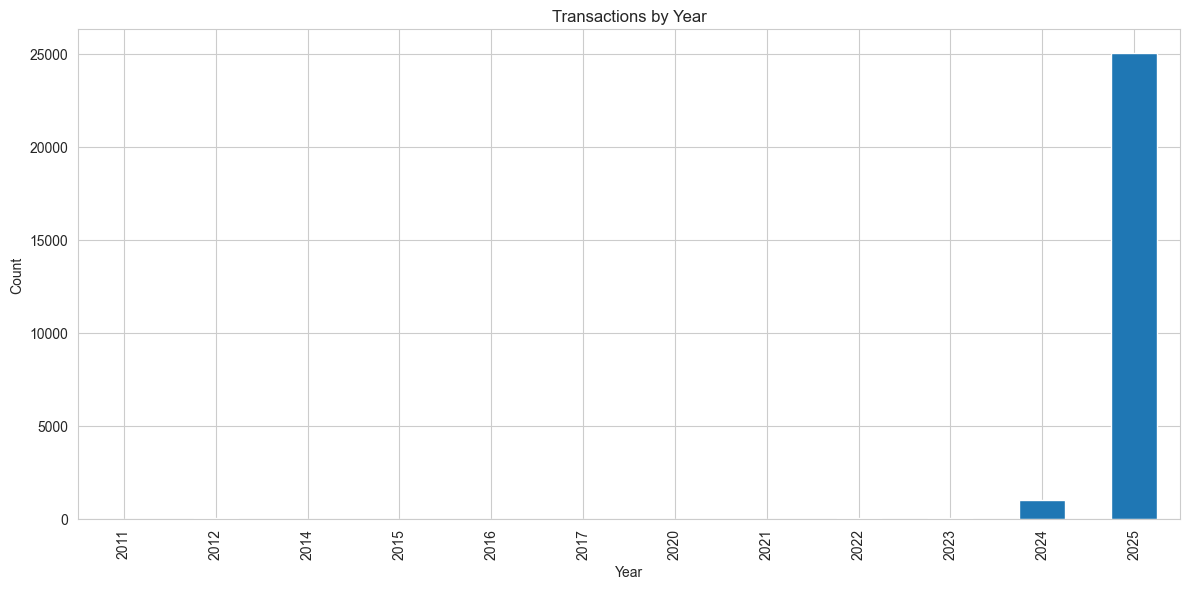

In [466]:
plt.figure()
df_filtered['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Transactions by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 5. Shares, price per share, and dollar value
We examine the distributions of:
- `TRANS_SHARES`
- `TRANS_PRICEPERSHARE`
- `dollar_value = TRANS_SHARES × TRANS_PRICEPERSHARE`
including summary statistics and selected percentiles.

In [467]:
numeric_cols = ['TRANS_SHARES', 'TRANS_PRICEPERSHARE']
for col in numeric_cols:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

df_filtered['dollar_value'] = df_filtered['TRANS_SHARES'] * df_filtered['TRANS_PRICEPERSHARE']

stats = df_filtered[['TRANS_SHARES', 'TRANS_PRICEPERSHARE', 'dollar_value']].describe()
stats

,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value
count,2.619000e+04,26149.000000,2.614900e+04
mean,7.813268e+04,239.322384,1.809489e+06
std,1.608907e+06,7266.819337,2.957734e+07
min,0.000000e+00,0.000000,0.000000e+00
25%,5.130000e+02,13.220000,2.512362e+04
50%,2.317500e+03,54.000000,1.368466e+05
75%,1.000575e+04,190.550000,5.453051e+05
max,1.946288e+08,878401.000000,2.740968e+09


In [468]:
percentiles = [10, 25, 50, 75, 90, 95, 99]
dv = df_filtered['dollar_value'].dropna()

pd.DataFrame({f'{p}th': [dv.quantile(p/100)] for p in percentiles})

,10th,25th,50th,75th,90th,95th,99th
0,3002.5008,25123.62,136846.6,545305.12,1826420.342,3832182.36,1.700894e+07


In [469]:
# Drop rows with transaction with no value
df_filtered = df_filtered[df_filtered['TRANS_SHARES'] > 0]
print('Records after filtering:', len(df_filtered))
df_filtered = df_filtered[df_filtered['TRANS_PRICEPERSHARE'] > 0]
print('Records after filtering:', len(df_filtered))

# Recompiled dollar value
df_filtered['dollar_value'] = df_filtered['TRANS_SHARES'] * df_filtered['TRANS_PRICEPERSHARE']

stats = df_filtered[['TRANS_SHARES', 'TRANS_PRICEPERSHARE', 'dollar_value']].describe()
stats


Records after filtering: 26159
Records after filtering: 26056


,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value
count,2.605600e+04,26056.000000,2.605600e+04
mean,7.124525e+04,240.174041,1.815947e+06
std,1.563206e+06,7279.762767,2.962988e+07
min,4.000000e-02,0.010000,1.184000e+00
25%,5.187500e+02,13.530000,2.579625e+04
50%,2.316000e+03,54.275000,1.389660e+05
75%,1.000000e+04,191.430000,5.493582e+05
max,1.946288e+08,878401.000000,2.740968e+09


Let's remove the rows with transaction dates that did not happen in year 2025

In [470]:
df_filtered = df_filtered[df_filtered['year'] == 2025]
print('Records after filtering for 2025 only:', len(df_filtered))

Records after filtering for 2025 only: 24959


## Multiple transactions per submision 

In [471]:
df_filtered.head()

,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_DATE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE,year,year_month,dollar_value
12,0001079973-25-000565,Common Stock,2025-03-28,S,842.0,50.00,2025,2025-03,42100.00
13,0001079973-25-000565,Common Stock,2025-03-31,S,836.0,50.00,2025,2025-03,41800.00
14,0002003074-25-000007,Common Stock,2025-03-31,P,1068297.0,6.77,2025,2025-03,7232370.69
15,0002003074-25-000007,Common Stock,2025-03-27,P,1157742.0,6.15,2025,2025-03,7120113.30
16,0002003074-25-000007,Common Stock,2025-03-28,P,1333188.0,6.70,2025,2025-03,8932359.60


In [472]:
# Let's check how many rows have unique ACCESSION_NUMBER
print('Number of unique ACCESSION_NUMBER:', df_filtered['ACCESSION_NUMBER'].nunique())

Number of unique ACCESSION_NUMBER: 11776


We have that about half of the transaction have unique ids. We now know that is common to have multiple transaction for one SEC submision

In [473]:
# Group by ACCESSION_NUMBER and calculate the time span for each
grouped_dates = df_filtered.groupby('ACCESSION_NUMBER')['TRANS_DATE']
time_windows = grouped_dates.max() - grouped_dates.min()

# Find the largest time window
largest_window = time_windows.max()
print(f'Largest time window between transactions for the same ACCESSION_NUMBER: {largest_window}')

# Find the ACCESSION_NUMBER with the largest time window
accession_with_largest_window = time_windows.idxmax()
print(f'ACCESSION_NUMBER with largest time window: {accession_with_largest_window}')

# Show all rows for that ACCESSION_NUMBER
rows_for_largest = df_filtered[df_filtered['ACCESSION_NUMBER'] == accession_with_largest_window]
rows_for_largest

Largest time window between transactions for the same ACCESSION_NUMBER: 53 days 00:00:00
ACCESSION_NUMBER with largest time window: 0000947871-25-000303


,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_DATE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE,year,year_month,dollar_value
16996,0000947871-25-000303,Common Stock,2025-01-16,P,0.04,112.27,2025,2025-01,4.4908
16998,0000947871-25-000303,Common Stock,2025-03-10,P,1000.00,86.92,2025,2025-03,86920.0000


In [474]:
# Group by ACCESSION_NUMBER and count unique TRANS_CODE
grouped_codes = df_filtered.groupby('ACCESSION_NUMBER')['TRANS_CODE'].nunique()
conflicting_accessions = grouped_codes[grouped_codes > 1]

print(f'Number of ACCESSION_NUMBER with conflicting TRANS_CODE: {len(conflicting_accessions)}')

if len(conflicting_accessions) > 0:
    print('Examples of conflicting ACCESSION_NUMBER:')
    for acc in conflicting_accessions.index[:5]:  # Show first 5 examples
        print(f'\nACCESSION_NUMBER: {acc}')
        print(df_filtered[df_filtered['ACCESSION_NUMBER'] == acc][['TRANS_CODE', 'TRANS_DATE']].sort_values('TRANS_DATE'))
else:
    print('No conflicting TRANS_CODE found.')

Number of ACCESSION_NUMBER with conflicting TRANS_CODE: 27
Examples of conflicting ACCESSION_NUMBER:

ACCESSION_NUMBER: 0000018349-25-000011
      TRANS_CODE TRANS_DATE
81286          P 2025-01-28
81287          S 2025-01-28

ACCESSION_NUMBER: 0000070858-25-000005
      TRANS_CODE TRANS_DATE
91497          S 2025-01-10
91517          S 2025-01-10
91516          S 2025-01-10
91515          S 2025-01-10
91514          S 2025-01-10
91513          S 2025-01-10
91512          S 2025-01-10
91511          S 2025-01-10
91510          S 2025-01-10
91509          S 2025-01-10
91518          S 2025-01-10
91508          S 2025-01-10
91506          S 2025-01-10
91505          S 2025-01-10
91504          S 2025-01-10
91503          S 2025-01-10
91502          S 2025-01-10
91501          S 2025-01-10
91500          S 2025-01-10
91499          P 2025-01-10
91498          S 2025-01-10
91507          S 2025-01-10
91519          S 2025-01-10

ACCESSION_NUMBER: 0000070858-25-000024
      TRANS_CODE TRANS_

A small number of rows with same ACCESSION_NUMBER have conflicting TRANS_CODE. Let's drop those rows

In [475]:
# Drop rows with conflicting TRANS_CODE
df_filtered = df_filtered[~df_filtered['ACCESSION_NUMBER'].isin(conflicting_accessions.index)]
print('Records after dropping conflicting TRANS_CODE:', len(df_filtered))

Records after dropping conflicting TRANS_CODE: 24807


Let's combine the transactions that are part of the same submision (same ACCESSION_NUMBER)

In [476]:
# Sort by ACCESSION_NUMBER and TRANS_DATE
df_filtered = df_filtered.sort_values(['ACCESSION_NUMBER', 'TRANS_DATE'])

# Group by ACCESSION_NUMBER and aggregate
df_combined = df_filtered.groupby('ACCESSION_NUMBER').agg({
    'SECURITY_TITLE': 'last',
    'TRANS_CODE': 'last',
    'TRANS_SHARES': 'sum',
    'TRANS_PRICEPERSHARE': lambda x: (df_filtered.loc[x.index, 'dollar_value'].sum() / 
                                       df_filtered.loc[x.index, 'TRANS_SHARES'].sum()) 
                                      if df_filtered.loc[x.index, 'TRANS_SHARES'].sum() > 0 else 0,
    'dollar_value': 'sum',
    'year': 'last',
    'year_month': 'last',
    'TRANS_DATE': 'last'
}).reset_index()

print('Shape after combining:', df_combined.shape)
df_combined.head()

Shape after combining: (11749, 9)


,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value,year,year_month,TRANS_DATE
0,0000002488-25-000014,Common Stock,P,4645.0,107.560000,499616.20,2025,2025-02,2025-02-07
1,0000002488-25-000016,Common Stock,S,17500.0,113.574009,1987545.16,2025,2025-02,2025-02-14
2,0000002488-25-000034,Common Stock,S,17500.0,100.267104,1754674.32,2025,2025-03,2025-03-14
3,0000003570-25-000038,Common Stock,S,23478.0,216.430000,5081343.54,2025,2025-02,2025-02-26
4,0000003570-25-000040,Common Stock,S,9000.0,219.510000,1975590.00,2025,2025-02,2025-02-27


In [477]:
# Show combined row for the ACCESSION_NUMBER =  0000947871-25-000303
rows_for_largest = df_combined[df_combined['ACCESSION_NUMBER'] == accession_with_largest_window]
rows_for_largest

,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value,year,year_month,TRANS_DATE
1107,0000947871-25-000303,Common Stock,P,1000.04,86.921014,86924.4908,2025,2025-03,2025-03-10


In [478]:
stats = df_combined[['TRANS_SHARES', 'TRANS_PRICEPERSHARE', 'dollar_value']].describe()
stats

,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value
count,1.174900e+04,11749.000000,1.174900e+04
mean,1.504954e+05,170.682080,3.893322e+06
std,2.380901e+06,7175.225091,4.851393e+07
min,4.000000e-02,0.020000,1.184000e+00
25%,1.657000e+03,10.056429,4.232060e+04
50%,6.221000e+03,31.323214,1.942384e+05
75%,2.259800e+04,98.485956,8.760090e+05
max,1.946288e+08,775883.300000,2.740968e+09


## 6. Visualizations
Below we plot:
- Buy vs Sell transaction counts
- Distribution of dollar values (log scale to handle skew)
These plots help visually confirm patterns seen in the summary statistics.

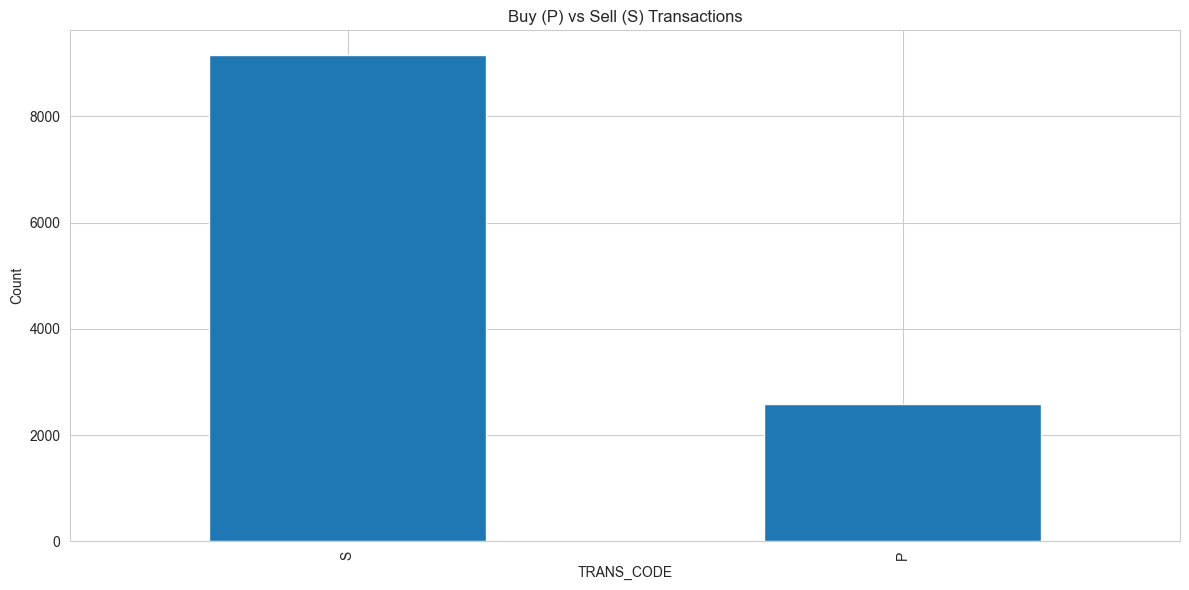

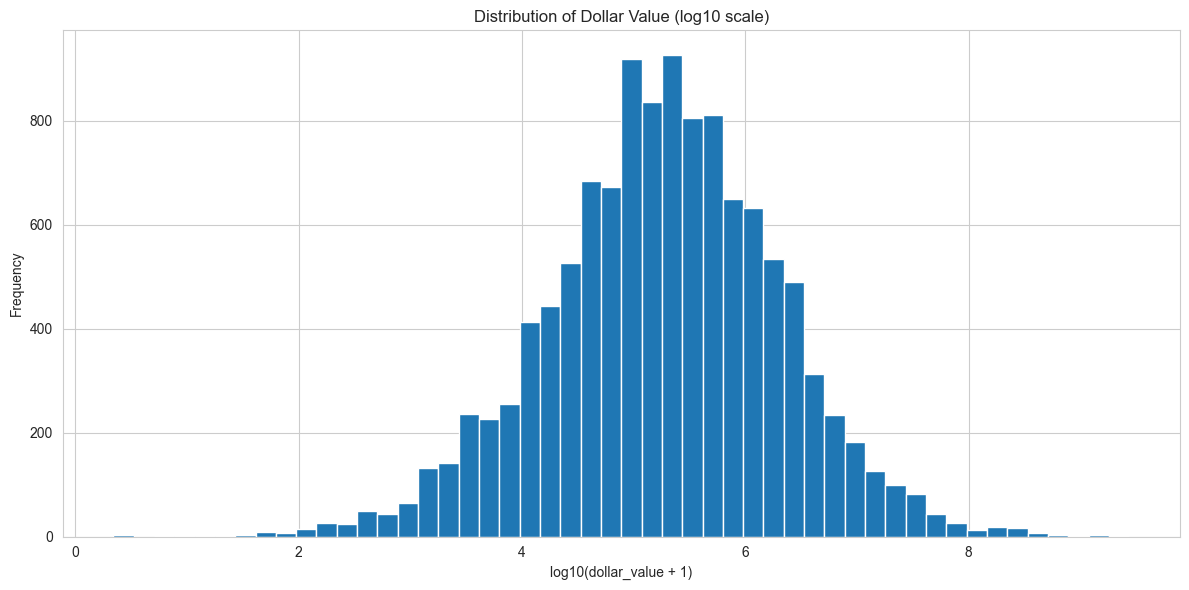

In [489]:
plt.figure()
df_combined['TRANS_CODE'].value_counts().plot(kind='bar')
plt.title('Buy (P) vs Sell (S) Transactions')
plt.xlabel('TRANS_CODE')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure()
dv_log = np.log10(df_combined['dollar_value'].dropna() + 1)    # log base 20
#dv_log = np.log1p(df_combined['dollar_value'].dropna() + 1)     # natural log
dv_log.plot(kind='hist', bins=50)
plt.title('Distribution of Dollar Value (log10 scale)')
plt.xlabel('log10(dollar_value + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

##  Monthly trends: counts, dollar value, buy/sell ratio

In [490]:
# Aggregate by month
monthly = (
    df_combined
    .groupby('year_month')
    .agg(
        n_trades=('TRANS_CODE', 'count'),
        total_dollar_value=('dollar_value', 'sum'),
        buys=('TRANS_CODE', lambda x: (x == 'P').sum()),
        sells=('TRANS_CODE', lambda x: (x == 'S').sum())
    )
)

monthly['buy_sell_ratio'] = monthly['buys'] / monthly['sells'].replace(0, np.nan)

monthly.tail()


,n_trades,total_dollar_value,buys,sells,buy_sell_ratio
year_month,,,,,
2025-01,2907,7.759946e+09,539,2368,0.227618
2025-02,4239,2.086547e+10,841,3398,0.247499
2025-03,4601,1.711722e+10,1204,3397,0.354430
2025-10,2,4.637902e+03,2,0,NaN


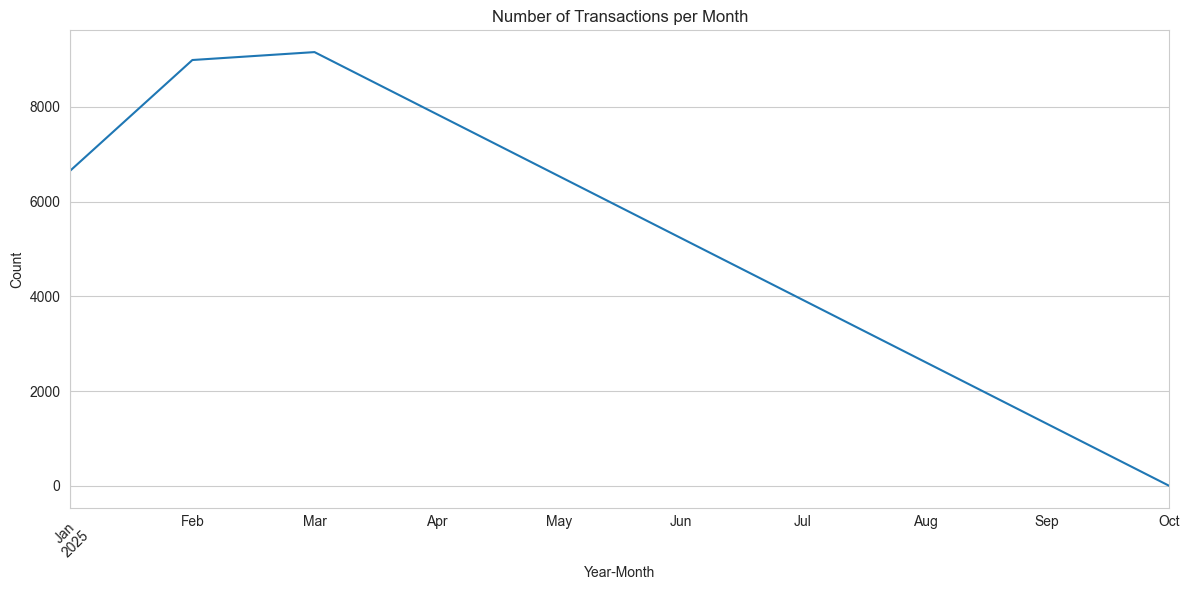

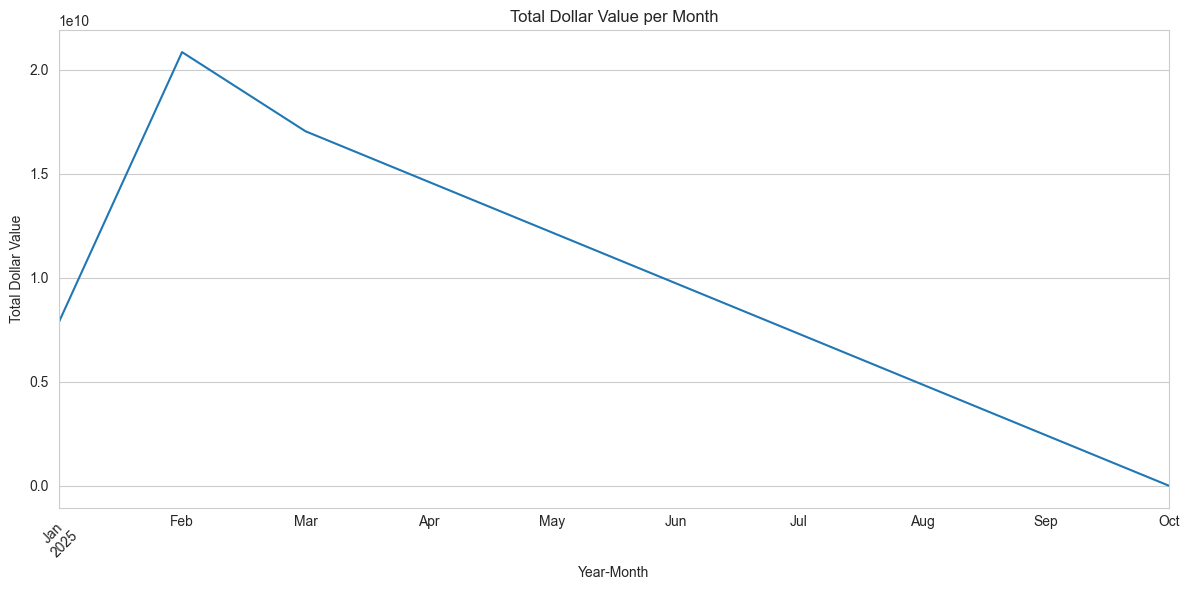

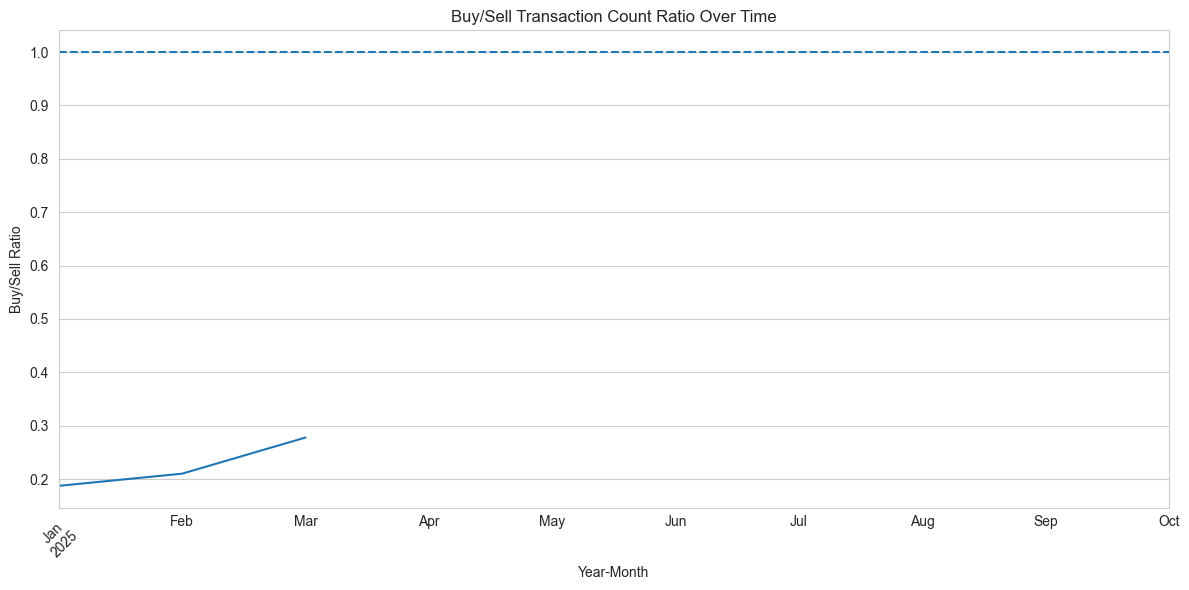

In [481]:
# Plot: trades per month
plt.figure()
monthly['n_trades'].plot()
plt.title('Number of Transactions per Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: total dollar value per month
plt.figure()
monthly['total_dollar_value'].plot()
plt.title('Total Dollar Value per Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Dollar Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: buy/sell ratio over time
plt.figure()
monthly['buy_sell_ratio'].plot()
plt.title('Buy/Sell Transaction Count Ratio Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Buy/Sell Ratio')
plt.xticks(rotation=45)
plt.axhline(1, linestyle='--')
plt.tight_layout()
plt.show()


Here we analyse when insiders are more net-buy vs net-sell and how intensity changes over time

## Compare buy vs sell behaviour (size, price, dollar value)

In [491]:
buy_sell_summary = (
    df_combined
    .groupby('TRANS_CODE')
    .agg(
        n_trades=('dollar_value', 'count'),
        median_dollar_value=('dollar_value', 'median'),
        mean_dollar_value=('dollar_value', 'mean'),
        median_shares=('TRANS_SHARES', 'median'),
        mean_shares=('TRANS_SHARES', 'mean'),
        median_price=('TRANS_PRICEPERSHARE', 'median'),
        mean_price=('TRANS_PRICEPERSHARE', 'mean')
    )
)

buy_sell_summary


,n_trades,median_dollar_value,mean_dollar_value,median_shares,mean_shares,median_price,mean_price
TRANS_CODE,,,,,,,
P,2586,50104.0,2.588314e+06,5000.0,149792.789903,12.900080,83.761023
S,9163,261952.6,4.261623e+06,6498.0,150693.716798,42.748856,195.213113


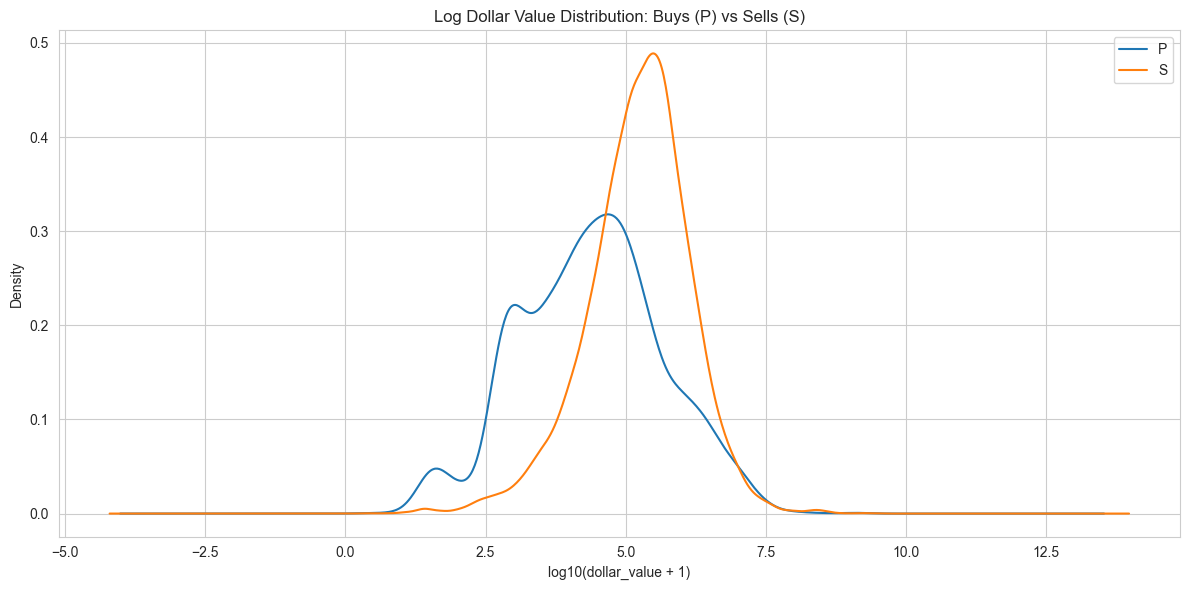

In [483]:
# Visual: distribution of log-dollar value by P vs S
plt.figure()
for code in ['P', 'S']:
    subset = np.log10(df_filtered.loc[df_filtered['TRANS_CODE'] == code, 'dollar_value'] + 1)
    subset.plot(kind='kde', label=code)
plt.title('Log Dollar Value Distribution: Buys (P) vs Sells (S)')
plt.xlabel('log10(dollar_value + 1)')
plt.legend()
plt.tight_layout()
plt.show()


Checking if sells are larger than buys, if buys happen at lower/higher prices, etc.

## Flag and inspect large / extreme trades (outliers)

In [492]:
# Define threshold as 99th percentile of dollar_value
threshold_99 = df_combined['dollar_value'].quantile(0.99)

large_trades = df_combined[df_combined['dollar_value'] >= threshold_99].copy()
large_trades_sorted = large_trades.sort_values('dollar_value', ascending=False)

threshold_99, large_trades_sorted.head(20)


(np.float64(48140714.39040012),
            ACCESSION_NUMBER                             SECURITY_TITLE  \
 3821   0001104659-25-019307    Common Stock, par value $0.01 per share   
 8164   0001493152-25-008579                       Class A Common Stock   
 6801   0001415889-25-005456                               Common Stock   
 2546   0000950170-25-038061                       Class A Common Stock   
 2545   0000950170-25-038059                       Class A Common Stock   
 10405  0001641172-25-001770                               Common Stock   
 4173   0001127602-25-001988                               Common Stock   
 3944   0001104659-25-028273                       Class A Common Stock   
 4791   0001127602-25-009538                                     Common   
 2276   0000950170-25-032518                               Common Stock   
 2273   0000950170-25-032506                               Common Stock   
 2274   0000950170-25-032510                               Common St

In [485]:
# How many large trades are buys vs sells?
large_trades['TRANS_CODE'].value_counts(normalize=True)


TRANS_CODE
S    0.835341
P    0.164659
Name: proportion, dtype: float64

## Security-level view: which securities see most insider activity?

In [493]:
group_cols = []
if 'ISSUER_CIK' in df_combined.columns:
    group_cols.append('ISSUER_CIK')
if 'ISSUER_TRADING_SYMBOL' in df_combined.columns:
    group_cols.append('ISSUER_TRADING_SYMBOL')

# Always include security title as a fallback
group_cols.append('SECURITY_TITLE')

security_activity = (
    df_combined
    .groupby(group_cols)
    .agg(
        n_trades=('dollar_value', 'count'),
        total_dollar_value=('dollar_value', 'sum'),
        net_dollar_value=('dollar_value', lambda x: x[df_combined.loc[x.index, 'TRANS_CODE'] == 'P'].sum()
                                              - x[df_combined.loc[x.index, 'TRANS_CODE'] == 'S'].sum())
    )
    .sort_values('total_dollar_value', ascending=False)
)

security_activity.head(20)


,n_trades,total_dollar_value,net_dollar_value
SECURITY_TITLE,,,
Common Stock,7512,2.021407e+10,-1.723453e+10
Class A Common Stock,2158,1.550636e+10,-7.998856e+09
"Common Stock, par value $0.01 per share",99,3.465692e+09,-3.213027e+09
Common,55,1.120718e+09,-1.119968e+09
Common Shares,391,8.118454e+08,-6.571810e+08
"Class A Common Stock, par value $0.0001 per share",9,5.227019e+08,-5.227019e+08
"Common Stock, no par value",23,3.921533e+08,-2.380037e+08
Common Shares of Beneficial Interest,33,3.671109e+08,1.886705e+08
"Common Stock, $0.0001 par value per share",9,3.388406e+08,3.349598e+08


Shows which companies/securities attract the most insider trading and whether insiders are net buyers or sellers.

# Stability and anomaly: month-over-month changes

In [494]:
monthly_changes = monthly[['n_trades', 'total_dollar_value']].copy()
monthly_changes['n_trades_change_pct'] = monthly_changes['n_trades'].pct_change() * 100
monthly_changes['dollar_value_change_pct'] = monthly_changes['total_dollar_value'].pct_change() * 100

monthly_changes.tail()


,n_trades,total_dollar_value,n_trades_change_pct,dollar_value_change_pct
year_month,,,,
2025-01,2907,7.759946e+09,NaN,NaN
2025-02,4239,2.086547e+10,45.820433,168.886778
2025-03,4601,1.711722e+10,8.539750,-17.963898
2025-10,2,4.637902e+03,-99.956531,-99.999973


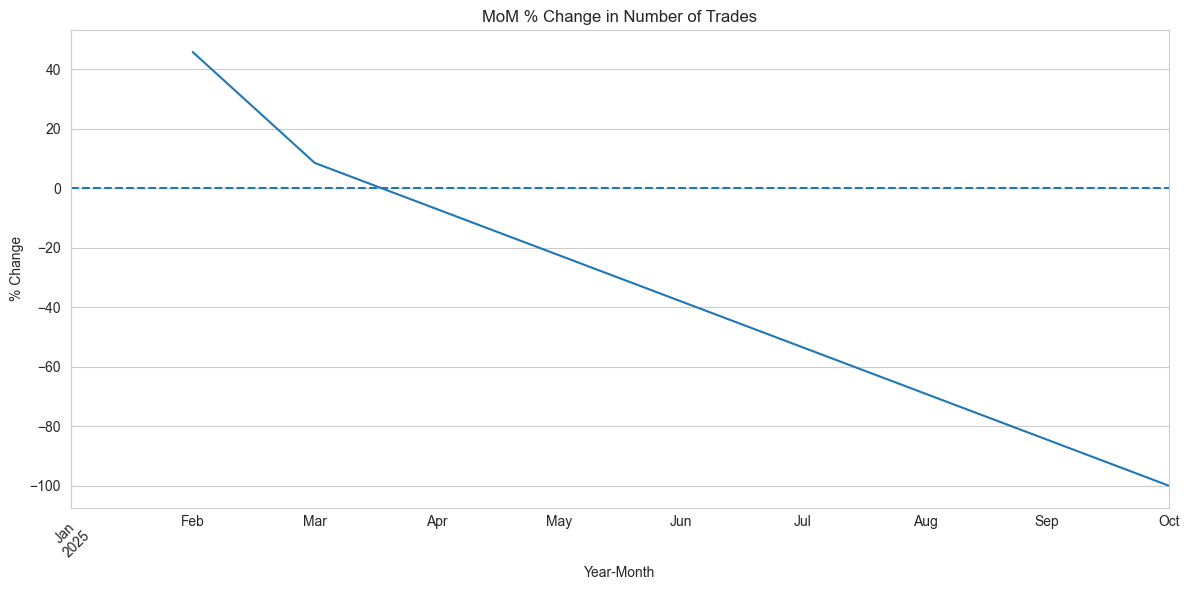

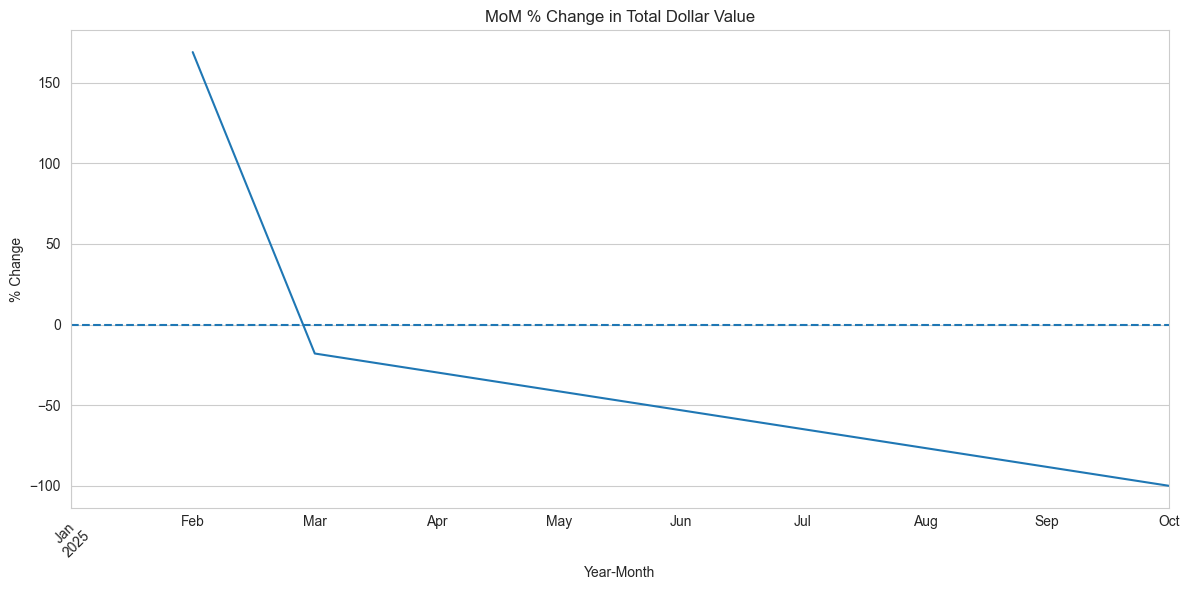

In [495]:
plt.figure()
monthly_changes['n_trades_change_pct'].plot()
plt.title('MoM % Change in Number of Trades')
plt.xlabel('Year-Month')
plt.ylabel('% Change')
plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
monthly_changes['dollar_value_change_pct'].plot()
plt.title('MoM % Change in Total Dollar Value')
plt.xlabel('Year-Month')
plt.ylabel('% Change')
plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Spikes here = months where insider activity is unusually high/low → candidate for deeper investigation.